# Alzheimer prediction using gray matter density from T1w MRI
### Gabriela BITTENCOURT

**Deadline**: Upload this notebook (rename it as 'TP4-Trees-YOUR-SURNAME.ipynb') with your answers and code to the Moodle/Ecampus before the deadline.


We will use a dataset composed of neuroimaging features from brain T1w MR images of 752 subjects, 416 controls and 336 with Alzheimer’s disease. Following the pipeline described in [1], all images are first normalized to a
common space, providing a voxel-wise correspondence across subjects. Then, gray matter density is computed at each voxel and averaged over a set of ROIs (Region of Interest) of an atlas, at the beginning you will use the [AAL2 atlas](http://www.gin.cnrs.fr/en/tools/aal/). Data comes from several freely available datasets, like [ADNI](http://adni.loni.usc.edu/) and [OASIS](https://www.oasis-brains.org/), and has been pre-processed by the [Clinica](http://www.clinica.run/) team using the procedure explained in [1].

Please load the data from the file: *dataTP.npz* where *T1xxxx* is a matrix containing the averaged density (each row is a subject and each column a feature), *y* is a vector containing the diagnosis (0 for controls and 1 for Alzheimer’s patients) and *ROIlabelsx* contains the name of the ROI of each feature. Here, *x* can take the name of the three atlases you have at your disposal: AAL2, [AICHA](http://www.gin.cnrs.fr/fr/outils/aicha/), [HAMMERS](https://brain-development.org/brain-atlases/adult-brain-atlases/).

**Reference**:
[1] J. Samper-González, N. Burgos, S. Bottani, S. Fontanella, P. Lu, A. Marcoux, A. Routier, J. Guillon, M. Bacci, J. Wen, A. Bertrand, H. Bertin, M.-O. Habert, S. Durrleman, T. Evgeniou, O. Colliot. *Reproducible evaluation of classification methods in Alzheimer's disease: framework and application to MRI and PET data*. NeuroImage, 2018 

In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import warnings
warnings.filterwarnings('ignore', category=ImportWarning)

# Libraries
import numpy as np
import matplotlib.pyplot as plt
!pip install -q nilearn
from nilearn import plotting
%matplotlib inline
np.random.seed(seed=666)

from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler



In [2]:
# from google_drive_downloader import GoogleDriveDownloader as gdd
# gdd.download_file_from_google_drive(file_id='11cQmPm64k3T7ml5fPLetZgb1j1AjHBH8',
# dest_path='./dataTP.npz')
# gdd.download_file_from_google_drive(file_id='1S7e5IrPygE4VV0JTwqJIlyO2S_NhsiI4',
# dest_path='./AtlasAAL2.nii')
# gdd.download_file_from_google_drive(file_id='1E0pu5jIMpgcs2DQ8lBGWliwEBZvKrnV9',
# dest_path='./AtlasAICHA.nii')
# gdd.download_file_from_google_drive(file_id='1yltKwULrkHYh79RAh_zAg08r8pQMjRlQ',
# dest_path='./AtlasHAMMERS.nii')

with np.load('./dataTP.npz',allow_pickle=True) as data:
    T1AAL2 = data['T1AAL2'] # data from AAL2 Atlas
    T1AICHA = data['T1AICHA'] # data from AICHA Atlas
    T1HAMMERS = data['T1HAMMERS'] # data from HAMMERS Atlas  
    y = data['y'] # classes, 0 for controls and 1 for patients    
    ROIlabelsAAL2 = data['ROIlabelsAAL2'] # labels for ROIs of atlas AAL2 
    ROIlabelsAICHA = data['ROIlabelsAICHA']    # labels for ROIs of atlas AICHA 
    ROIlabelsHAMMERS = data['ROIlabelsHAMMERS']    # labels for ROIs of atlas HAMMERS 

In [3]:
# Choose Atlas (here AAL2)
X=T1AAL2 # T1AAL2, T1AICHA, T1HAMMERS
labels=ROIlabelsAAL2 # ROIlabelsAAL2, ROIlabelsAICHA, ROIlabelsHAMMERS
atlas='./AtlasAAL2.nii' #AtlasAAL2.nii, AtlasAICHA.nii, AtlasHAMMERS.nii

N,M = X.shape # number subjects and ROIs
class_names = ["control","alzheimer"] # y=0, y=1

print('Number of controls and Alzheimer patients is respectively: {0} and {1}'.format(N-np.sum(y), np.sum(y)))
print('Number of ROI (features) is: {0}'.format(M))

Number of controls and Alzheimer patients is respectively: 416.0 and 336.0
Number of ROI (features) is: 120


Using the library nilearn we can also plot the atlas used to define the ROIs:

/home/gbittencourt/.local/lib/python3.8/site-packages/nilearn/plotting/img_plotting.py:348: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()


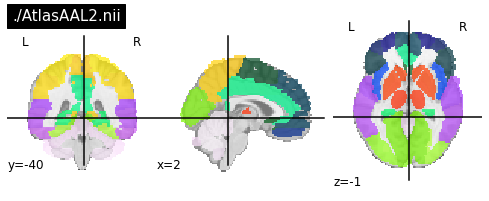

In [4]:
plotting.plot_roi(atlas, title=atlas)
plotting.show()

In this TP we will use Decision Trees, Bagging and Random Forests. Let's start with Decision Trees. First of all, we need to create a training and test set.

In [5]:
# Create training and test set
#X_train, X_test, y_train, y_test = train_test_split(X, np.ravel(y), test_size=0.3, random_state=0)
#X_train, X_test, y_train, y_test = train_test_split(X, np.ravel(y), test_size=0.3, random_state=200)
X_train, X_test, y_train, y_test = train_test_split(X, np.ravel(y), test_size=0.3, random_state=42)

And then we need to check whether out features need to be standardized or normalized. Let's have a look at them. Remember that if features can have both negative and positive values, as a rule of thumb, they should be standardized. If they only have positive values, a normalization is usually used. 

As already said, please remember that you should learn the standardization/normalization (namely learn the average/std or the max/min values) ONLY in the training set and then use the same values also in the test set. You should NOT use the entire dataset (both training and test) for standardization/normalization. Otherwise, you would have a *data leakage*, namely you would use data (the test set) that you should not use during training. 

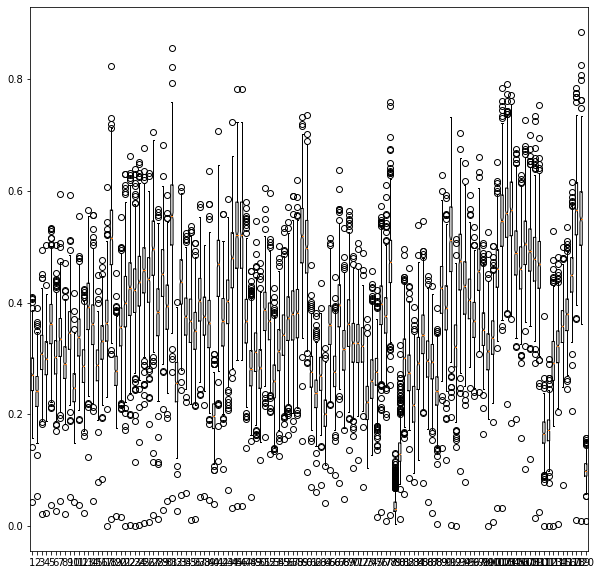

In [6]:
plt.figure(figsize=(10,10))
plt.boxplot(X,notch=True);

# Standardization/Normalization
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Then, we can fit a Decision tree, with the default setting, using the following code:

In [7]:
# Fitting Decision Trees 
Tree = DecisionTreeClassifier(random_state=0)
Tree.fit(X_train,y_train)
# Score in the training set
print('Score in the training set is {0}'.format(Tree.score(X_train,y_train)) )
# Score in the test set
print('Score in the test set is {0}'.format(Tree.score(X_test,y_test)) )

Score in the training set is 1.0
Score in the test set is 0.7389380530973452


Instead than using the default hyperparameters, we could also look for the best ones. Among the hyperparameters implemented in *scikit-learn* we could use *'min_samples_split'*, the minimum number of samples required to split an internal node, and/or *'min_samples_leaf'*, the minimum number of samples required to be present at a leaf node. A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches. 

Plot the training and test score for different values of 'min_samples_split' (for instance between 2 and 15) WITHOUT using Cross Validation. Do the same for 'min_samples_leaf'.

**Question:** What is the best value ? What happens if you split differently your data (change `random_state` in the function `train_test_split`) ?

**Answer:** The best fit is the one that maximizes the test score. So we'll consider the best value as the i that we chose that provides the highest test score. For a constant `min_samples_leaf` we have: `min_samples_split=11` with *best test score = 0.765* as the best option. For a constant `min_samples_split` we have: `min_samples_leaf=10` with *best test score = 0.792* as the best option.
Applying the best `min_samples_split=11` and `min_samples_leaf=10`, we get a *best test score = 0.792*

Changing the `random_state` on `train_test_split` makes smallers values of the `min_samples` overfitting the data.

The value of min_samples_split that maximizes the training score is :  2
The value of min_samples_split that maximizes the test score is :  11
The maximum test score is :  0.7654867256637168


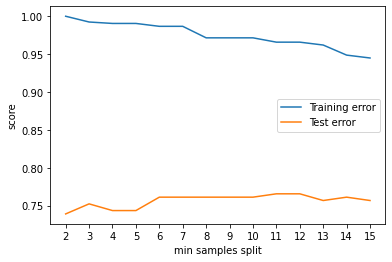

In [8]:
# min_samples_split

TTest=[]
TTrain=[]
for i in range(2,16):
    Tree = DecisionTreeClassifier(min_samples_split=i, random_state=0)
    Tree.fit(X_train,y_train)
    scoreTrain=Tree.score(X_train,y_train)
    scoreTest=Tree.score(X_test,y_test)
    TTrain.append(scoreTrain)
    TTest.append(scoreTest)
plt.plot(TTrain,label='Training error');
plt.xticks(np.arange(14), ('2', '3', '4', '5', '6','7','8','9','10','11','12','13','14','15'))
print("The value of min_samples_split that maximizes the training score is : ",TTrain.index(max(TTrain))+2)
plt.plot(TTest,label='Test error');
plt.xticks(np.arange(14), ('2', '3', '4', '5', '6','7','8','9','10','11','12','13','14','15'))
plt.xlabel('min samples split')
plt.ylabel('score')
print("The value of min_samples_split that maximizes the test score is : ",TTest.index(max(TTest))+2)
print("The maximum test score is : ",max(TTest))
plt.legend();

The value of min_samples_leaf that maximizes the training score is :  2
The value of min_samples_leaf that maximizes the test score is :  10
The maximum test score is :  0.7920353982300885


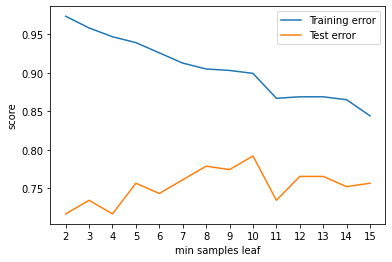

In [9]:
# min_samples_leaf

TTest=[]
TTrain=[]
for i in range(2,16):
    Tree = DecisionTreeClassifier(min_samples_leaf=i, random_state=0)
    Tree.fit(X_train,y_train)
    scoreTrain=Tree.score(X_train,y_train)
    scoreTest=Tree.score(X_test,y_test)
    TTrain.append(scoreTrain)
    TTest.append(scoreTest)
plt.plot(TTrain,label='Training error');
plt.xticks(np.arange(14), ('2', '3', '4', '5', '6','7','8','9','10','11','12','13','14','15'))
print("The value of min_samples_leaf that maximizes the training score is : ",TTrain.index(max(TTrain))+2)
plt.plot(TTest,label='Test error');
plt.xticks(np.arange(14), ('2', '3', '4', '5', '6','7','8','9','10','11','12','13','14','15'))
plt.xlabel('min samples leaf')
plt.ylabel('score')
print("The value of min_samples_leaf that maximizes the test score is : ",TTest.index(max(TTest))+2)
print("The maximum test score is : ",max(TTest))
plt.legend();

In [10]:
# best min_samples_split and min_samples_leaf

Tree = DecisionTreeClassifier(min_samples_leaf=10, min_samples_split=11, random_state=0)
Tree.fit(X_train,y_train)
scoreTrain=Tree.score(X_train,y_train)
scoreTest=Tree.score(X_test,y_test)

print(scoreTest)

0.7920353982300885


Try to add Gaussian noise to the data (using for instance zero mean and 0.05 for $\sigma$) and, using the best hyperparameters found before in the test set (you can use both `min_samples_leaf` and `min_samples_split`), look at the test score. Repeat this process several times and compare the results with the score obtained without adding noise. 

**Question**: Are the results stable ? Hint: you could use for instance *noise = np.random.normal(mu, sigma)* if you have standardized the features and *noise = np.abs(np.random.normal(mu, sigma))* if you have normalized them (we use *np.asb()* to take only positive values and $\sigma$ should be small in order to (almost) preserve the range of the features between 0 and 1)

**Answer:** The results are **not stable**. We observe that addition of a gaussian noise to the data implies in a variety of the score from 0.6 to 0.8. 

In [11]:
def add_gaussian_noise(X, mu, sigma):
    """ Add a gaussian noise to a X array

    Parameters
    ----------
    X:  [Nxd] matrix
        signal to be added the gaussian noise
    mu, sigma: 
        mean and variance of gaussian noise

    Return
    ------
    X_temp: [Nxd] matrix
            signal X + gaussian noise
    """ 
    X_temp = np.copy(X)
    for i in range(X_temp.shape[0]):
        noise = np.abs(np.random.normal(mu,sigma))
        X_temp[i] += noise
    return X_temp

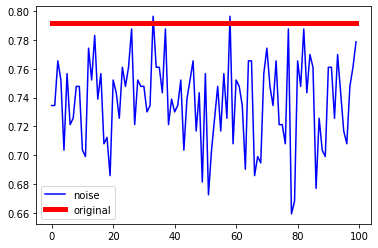

In [12]:
Tree = DecisionTreeClassifier(min_samples_split=11,min_samples_leaf=10,random_state=0)
scoreTestnoise=np.zeros(100)
scoreTest=np.zeros(100)

Tree.fit(X_train,y_train)
scoreTest[:] = Tree.score(X_test,y_test)  

for k in range(100):
    Tree.fit(add_gaussian_noise(X_train, 0, 0.05),y_train)
    scoreTestnoise[k] = Tree.score(X_test,y_test)
    
plt.plot(scoreTestnoise,'b',label='noise')
plt.plot(scoreTest,'r',linewidth=5.0,label='original')       
plt.legend();

To plot decision trees, we can also use the *graphviz* library. If you need to install it locally, you can do it using *conda install python-graphviz*. 
 

First plot the tree learnt on the original data, witout adding noise.

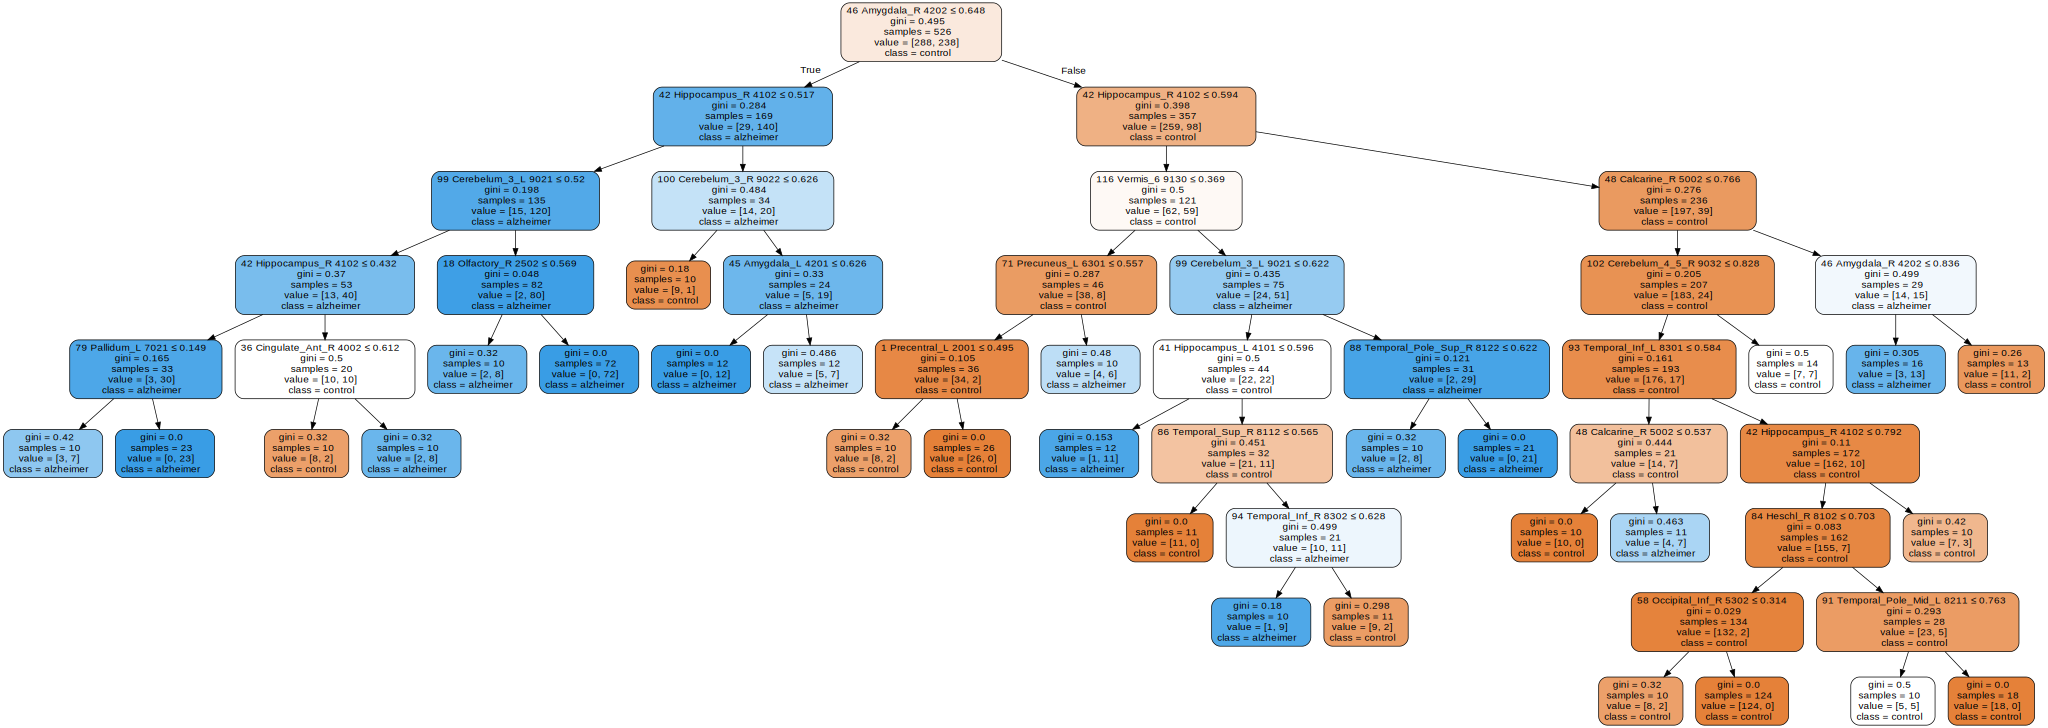

In [13]:
import graphviz 

def construct_graph(Tree, X, y):
    """ Computes the graph given a Tree and data(X,y) 

    Parameters
    ----------
    Tree:
        model of tree to be contructed
    X, y: [N,d] and [N,] vectors
        signals to be fitted on the tree model

    Return
    ------
    graph: graphviz.Graph()
        graph to be contructed
    """
    Tree.fit(X,y)
    dot_data = tree.export_graphviz(Tree, out_file=None,feature_names=labels,class_names=class_names,filled=True, rounded=True,special_characters=True)
    return graphviz.Source(dot_data)

graph = construct_graph(Tree,X_train,y_train)
graph

Now, plot the tree learnt on noisy data.

**Question**: Is it the same ? You can try several times, for different levels of noise. Comment the results

**Answer:** It depends on the noise to find the same tree. As smaller the variance more the tree of the noisy data gets closer to the original tree, namely with `sigma <= 0.1` the trees are close enough. As bigger the variance more differences can be noticed between the trees.

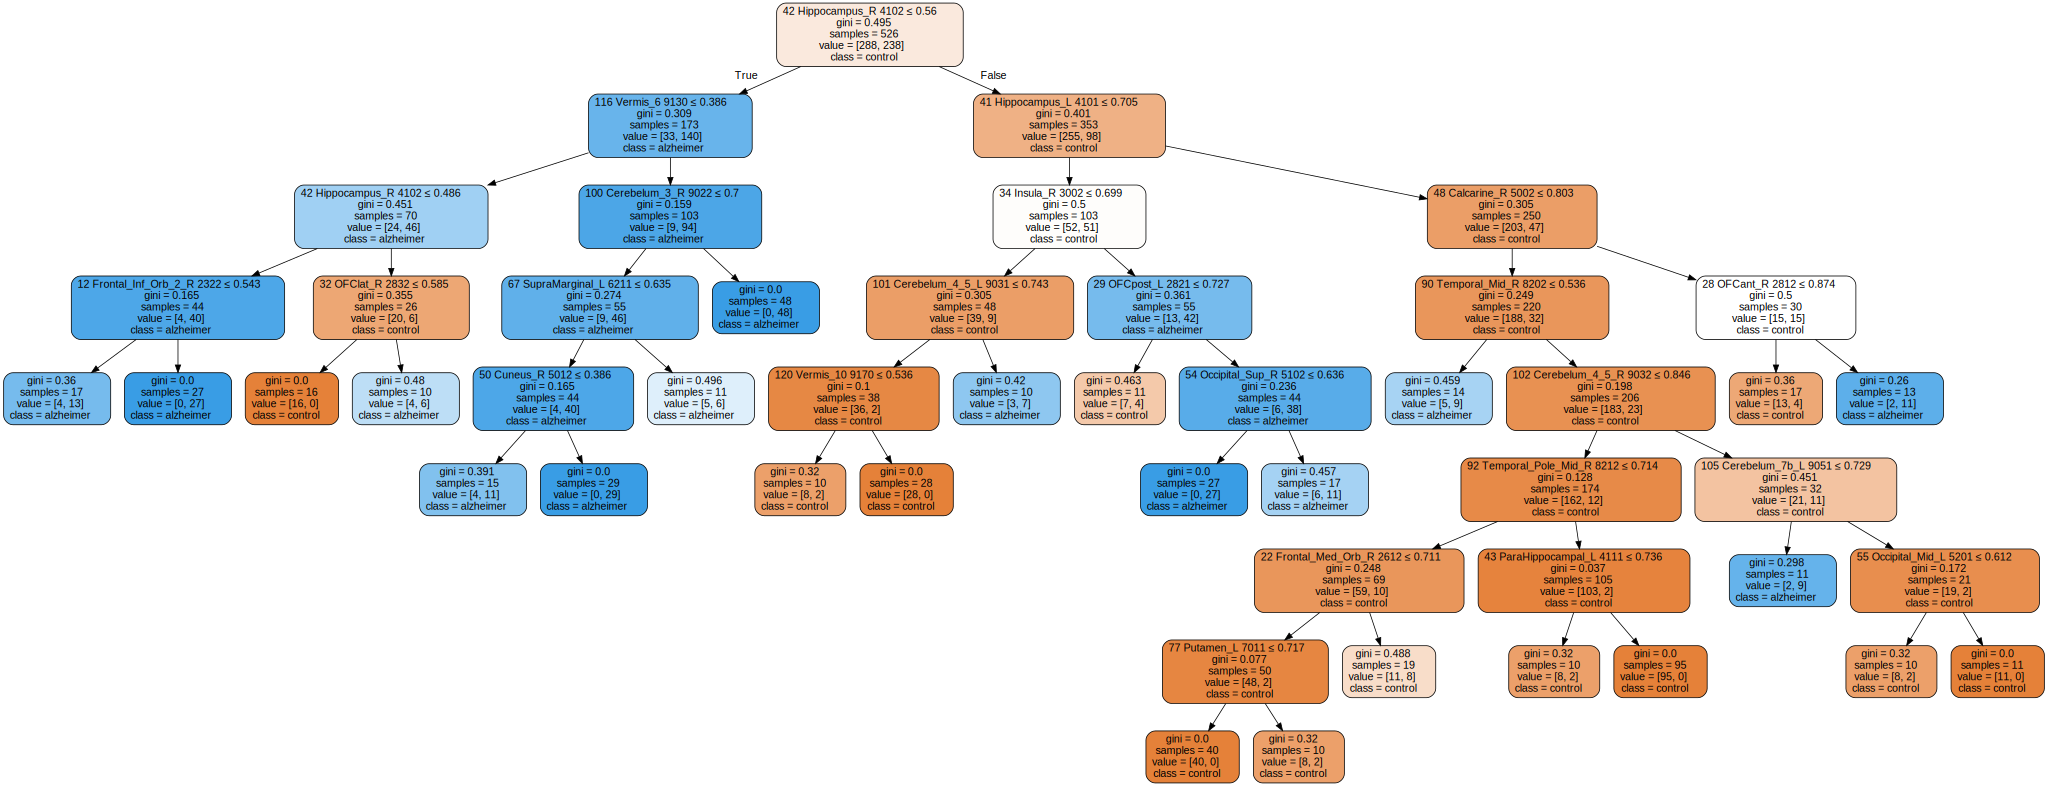

In [14]:
#X_train_noisy = add_gaussian_noise(X_train, 0, 0.2)
X_train_noisy = add_gaussian_noise(X_train,0,0.05)
graph = construct_graph(Tree, X_train_noisy, y_train)
graph

Instead than using a single split of the data, we could also use Cross Validation to compute the best hyperparameter values for both 'min_samples_split' and 'min_samples_leaf' at the same time and in an automatic way. 

**Question:** Do you find the same optimal hyperparameters as before ? Hint: use GridSearchCV

**Answer:** No, the optimal hyperparameters found using Cross Validation were: {'min_samples_leaf': 7, 'min_samples_split': 12}, while previously we had found 'min_samples_leaf': 11, 'min_samples_split': 10.

**Question**: So far, we have used the standard score (ie accuracy). Would you use a different one ? If yes, which one and why ?

**Answer:** We see a better score using `average_precision` scoring and worse score using `balanced_accuracy` and `precision` scoring. The `f1` scoring is indicated to binary targets.

In [15]:
def compute_best_params(estimator,p_grid,X=X_train,y=y_train,scoring="accuracy"):
    """ Use cross validation to compute the best parameters of a given estimator and grid on a given data (X,y). 

    Parameters
    ----------
    estimator:
        estimator to be fit the data in
    p_grid:
        grid that will serve as parameter on the GridSearchCV function
    X, y: [N,d] and [N,] vectors
        signals used to train the model
    scoring: 
        scoring to be used on GridSearchCV function

    Return
    ------
    best_param: dict ['min_samples_leaf', 'min_samples_split']
        the best hyperparameters found by the model
    """
    grid = GridSearchCV(estimator=estimator, param_grid=p_grid, cv=5,scoring=scoring)
    grid.fit(X,y)
    best_params = grid.best_params_

    print("Best Validation Score: {}".format(grid.best_score_))
    print("Best params: {}".format(best_params))
    print("Test score :",grid.score(X_test,y_test))
    return best_params

In [16]:
Tree = DecisionTreeClassifier()
p_grid_tree = {'min_samples_split': [2,3,4,5,6,7,8,9,10,11,12,13,14,15],
              'min_samples_leaf': [2,3,4,5,6,7,8,9,10,11,12,13,14,15] }

best_params = compute_best_params(Tree,p_grid_tree)

Best Validation Score: 0.7452830188679245
Best params: {'min_samples_leaf': 15, 'min_samples_split': 8}
Test score : 0.7477876106194691


In [17]:
Tree = DecisionTreeClassifier()
p_grid_tree = {'min_samples_split': [2,3,4,5,6,7,8,9,10,11,12,13,14,15],
              'min_samples_leaf': [2,3,4,5,6,7,8,9,10,11,12,13,14,15] }

#compute_best_params(Tree,p_grid_tree,scoring="balanced_accuracy");
compute_best_params(Tree,p_grid_tree,scoring="average_precision");
#compute_best_params(Tree,p_grid_tree,scoring="precision");

Best Validation Score: 0.7467495493756167
Best params: {'min_samples_leaf': 15, 'min_samples_split': 3}
Test score : 0.7918979535368877


Using the estimated optimal hyperparameers, plot the new decision tree using the *graphviz* library. 

**Question**: Is it the same as before? Do you see ROIs that are always close to the root of the tree among the different experiments ? If yes, what does it mean in your opinion ? Comment the results.

**Answer:** No, they are different trees. The nodes on the firsts layers are the same, noticeably: 46 Amygdala_R 4202, 45 Amygdala_L 4201, Hippocampus_R 4102, Hippocampus_R 4101; which may indicates that they are the most important features in predicting Alzheimer.

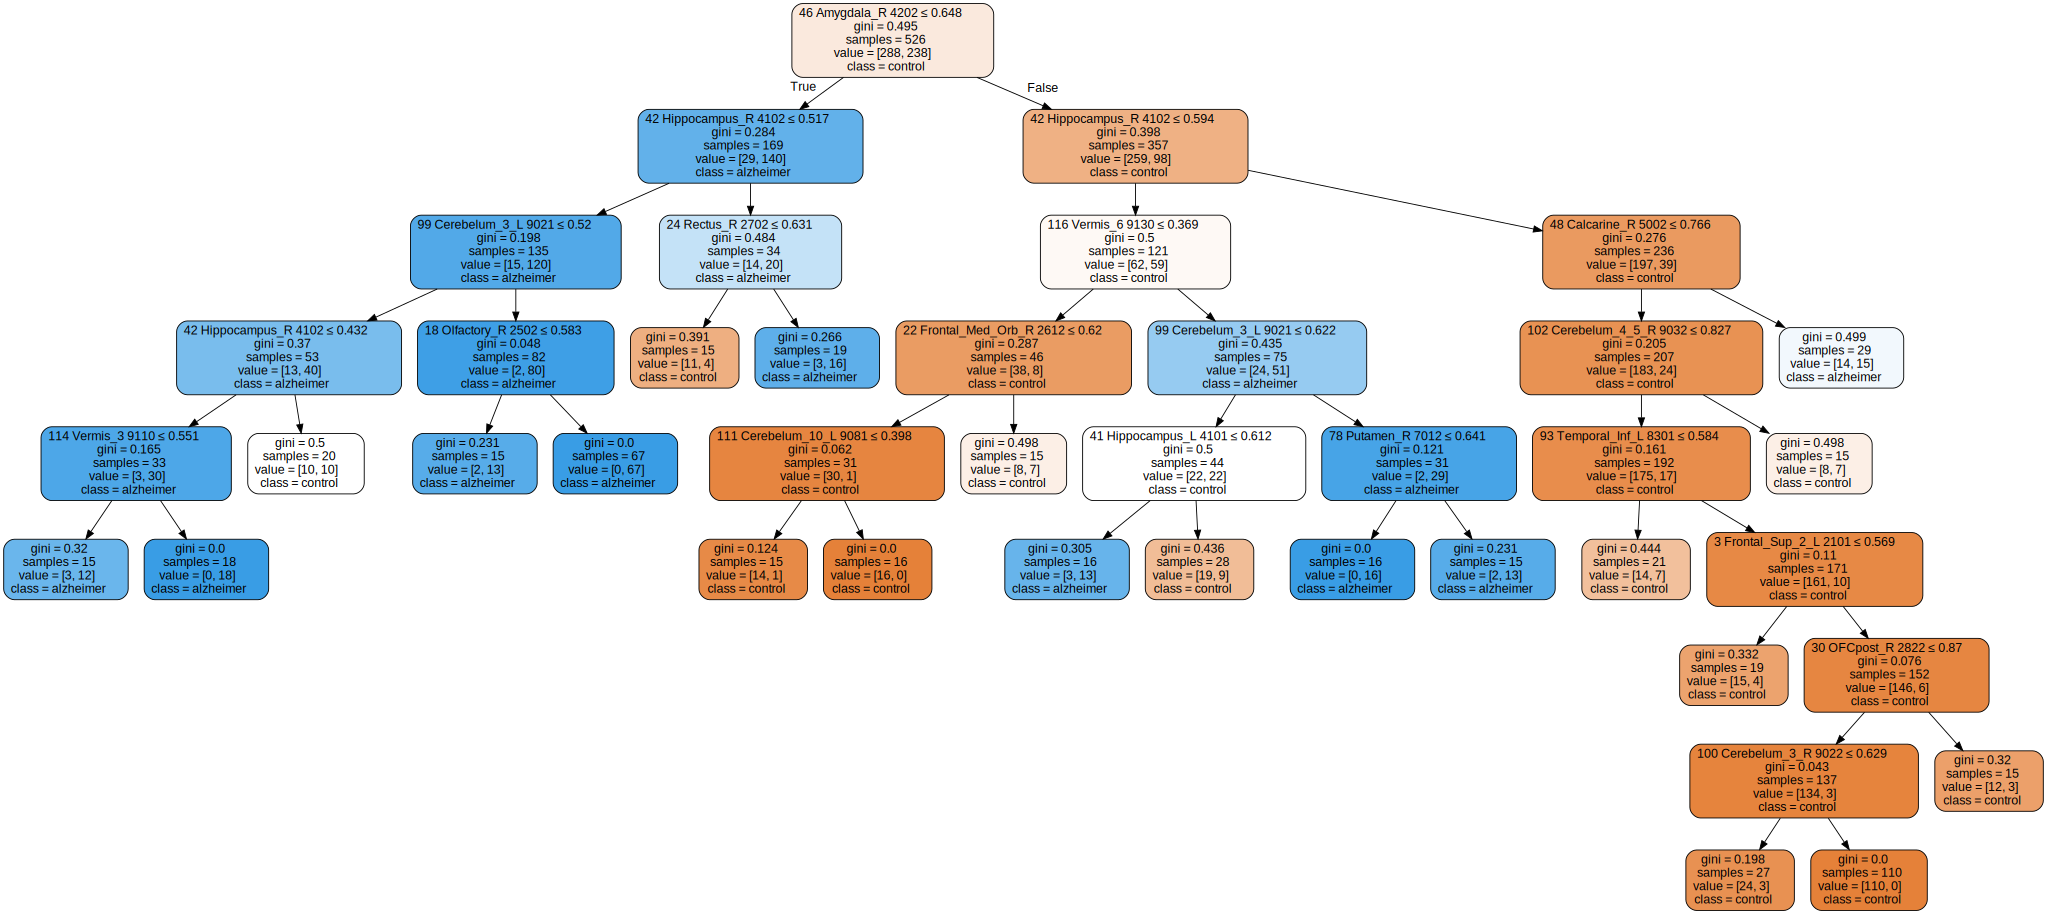

In [18]:
Tree = DecisionTreeClassifier(min_samples_leaf=best_params["min_samples_leaf"],min_samples_split=best_params["min_samples_split"], random_state=0)
graph = construct_graph(Tree, X_train, y_train)
graph

Try to use now Bagging. You can use the following code where we use the previously computed best parameters 'min_samples_leaf' and 'min_samples_split'. 

**Question**: What happens when you use the original data and the noisy version ? Do you notice any difference in the prediction scores with respect to the results using Decision Trees?

**Answer:** The difference of the scores on clean data and noisy data using bagging classifier is much smaller. We still see that the noisy data provides a worse score that the clean data, but not as much than when we test it without the bagging classifier. Therefore, the bagging classifier is a more stable algorithm than the decision tree. But, comparing the clean data of both classifiers we almost don't see a difference, concluding that both (decision tree and bagging) are good algorithm to applied on a clean data.

In [35]:
Tree = DecisionTreeClassifier(min_samples_leaf=best_params["min_samples_leaf"],min_samples_split=best_params["min_samples_split"], random_state=0)

p_grid_bagging = {'n_estimators': [5,10,15,20]}      
bag=BaggingClassifier(base_estimator=Tree, random_state=0)

compute_best_params(bag,p_grid_bagging,X=X_train,y=y_train,scoring='accuracy');

Best Validation Score: 0.8061096136567834
Best params: {'n_estimators': 20}
Test score : 0.8362831858407079


In [36]:
# Bagging on noisy data
Tree = DecisionTreeClassifier(min_samples_leaf=best_params["min_samples_leaf"],min_samples_split=best_params["min_samples_split"], random_state=0)
bag=BaggingClassifier(base_estimator=Tree, random_state=0)

compute_best_params(bag,p_grid_bagging,X=X_train_noisy,y=y_train,scoring='accuracy');

Best Validation Score: 0.7927403414195867
Best params: {'n_estimators': 10}
Test score : 0.8053097345132744


The last part of this TP is about Random Forests. We can estimate the three hyperparameters *'n_estimators'*, *'min_samples_leaf'* and *'max_features'*, the number of features to consider when looking for the best split, as before using Cross Validation

In [37]:
RF=RandomForestClassifier(random_state=0)
p_grid_RF = {'n_estimators': [10,15,20,25,30], 'min_samples_leaf': [2,3,4,5,6], 'max_features': ['sqrt','log2']}   

best_params = compute_best_params(RF,p_grid_RF,X=X_train,y=y_train,scoring='accuracy')

Best Validation Score: 0.8268823000898472
Best params: {'max_features': 'sqrt', 'min_samples_leaf': 3, 'n_estimators': 30}
Test score : 0.8185840707964602


**Question:** Using the estimated best hyperparameters, test the performance of Random Forest on the noisy data and compare the results with Decision Trees and Bagging.

**Answer:** The random forest presents the best score of the three, on the clean data and on the noisy data. The difference is much more noticeable on the noisy data, where the other two algorithms present worse result than the clean data and using the random forest, we have almost the same result as on clean data.

In [23]:
# Random Forest on noisy data
RF=RandomForestClassifier(random_state=0)
compute_best_params(RF,p_grid_RF,X=X_train_noisy,y=y_train,scoring='accuracy');

Best Validation Score: 0.8194070080862534
Best params: {'max_features': 'log2', 'min_samples_leaf': 4, 'n_estimators': 15}
Test score : 0.8141592920353983


We can also use Random Forests to check the importance of the features

In [46]:
def compute_important_features_RF_model(best_params):
    RF = RandomForestClassifier(min_samples_leaf=best_params["min_samples_leaf"],max_features=best_params["max_features"],n_estimators=best_params["n_estimators"], random_state=0)
    RF.fit(X_train,y_train)

    importances = RF.feature_importances_
    indices = np.argsort(importances)[::-1]

    return importances, indices

def plot_important_features(importances, indices):
    # Print the feature ranking
    print("Feature ranking:")

    for f in range(10):
        print("%d. feature %d representing %s (%f)" % (f + 1, indices[f], labels[indices[f]], importances[indices[f]]))

    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importance")
    plt.bar(range(10), importances[indices[0:10]], color="r", align="center")
    plt.xticks(range(10), indices[0:10])
    plt.xlim([-1, 10])
    plt.show()

Feature ranking:
1. feature 45 representing 46 Amygdala_R 4202
 (0.081412)
2. feature 44 representing 45 Amygdala_L 4201
 (0.078820)
3. feature 41 representing 42 Hippocampus_R 4102
 (0.061045)
4. feature 40 representing 41 Hippocampus_L 4101
 (0.050335)
5. feature 43 representing 44 ParaHippocampal_R 4112
 (0.029941)
6. feature 93 representing 94 Temporal_Inf_R 8302
 (0.026612)
7. feature 92 representing 93 Temporal_Inf_L 8301
 (0.025063)
8. feature 59 representing 60 Fusiform_R 5402
 (0.022801)
9. feature 42 representing 43 ParaHippocampal_L 4111
 (0.017602)
10. feature 81 representing 82 Thalamus_R 7102
 (0.016120)


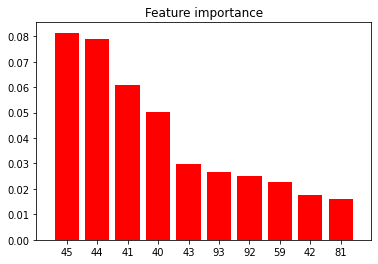

In [47]:
features = compute_important_features_RF_model(best_params)
plot_important_features(features[0],features[1])

**Question**: Which are the most important features (i.e. ROIs) ?  Based on the two given research papers, you can verify if your results make sense.

**Answer:**

We can also inspect the data using only pairs of the most important features

In [48]:
def plot_features_pairs(RF,indices):
    plt.figure(figsize=(15,7))
    for pairidx, pair in enumerate([ [indices[0],indices[1]], [indices[0],indices[2]], [indices[0],indices[3]],
                                    [indices[1],indices[2]], [indices[1],indices[3]], [indices[2],indices[3]] ]):
        # We only take the two corresponding features
        Xpair = X_train[:, pair]
        ypair = y_train

        # Train
        clf = RF.fit(Xpair, ypair)

        # Plot the decision boundary
        plt.subplot(2, 3, pairidx + 1)

        x_min, x_max = Xpair[:, 0].min() - 1, Xpair[:, 0].max() + 1
        y_min, y_max = Xpair[:, 1].min() - 1, Xpair[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                             np.arange(y_min, y_max, 0.02))
        plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)

        plt.xlabel(pair[0])
        plt.ylabel(pair[1])

        # Plot the training points
        for i, color in zip(range(2), "ym"):
            idx = np.where(ypair == i)
            plt.scatter(Xpair[idx, 0], Xpair[idx, 1], c=color, label=class_names[i],
                        cmap=plt.cm.RdYlBu, edgecolor='black', s=15)

    plt.suptitle("Decision surface of a random forest using couples of the most important features")
    plt.legend(bbox_to_anchor=(1, 0.5))
    plt.axis("tight")
    plt.show()

**Question**: Which is the best couple of features ?

**Answer:** The best couple of features may be (40,44) or (40,45), they seem to present a distict separation between the data.

**Different Atlas**

Previously, we have used the AAL2 which defines a precise split of the brain into ROIs. What happens if you change Atlas ? Do you obtain the same results ? Can you find a subset of ROIs that you could define 'biomarkers' of the Alzheimer's disease ? Justify your answer and check whether it makes sense by using the two given research papers.

You can use the AICHA (http://www.gin.cnrs.fr/fr/outils/aicha/) and HAMMERS (https://brain-development.org/brain-atlases/adult-brain-atlases/) atlas.

In [ ]:
data={
    'AAL2'    : {'X':T1AAL2,   'labels':ROIlabelsAAL2    },
    'AICHA'   : {'X':T1AICHA,  'labels':ROIlabelsAICHA   },
    'HAMMERS' : {'X':T1HAMMERS,'labels':ROIlabelsHAMMERS }
}

def train_RF_model(atlas='AAL2'):
    # Choose Atlas
    X=data[atlas]['X']
    labels=data[atlas]['labels']
    atlas='./Atlas'+atlas+'.nii'

    N,M = X.shape # number subjects and ROIs
    class_names = ["control","alzheimer"] # y=0, y=1

    print('Number of controls and Alzheimer patients is respectively: {0} and {1}'.format(N-np.sum(y), np.sum(y)))
    print('Number of ROI (features) is: {0}'.format(M))

    #plotting.plot_roi(atlas, title=atlas)
    #plotting.show()

    X_train, X_test, y_train, y_test = train_test_split(X, np.ravel(y), test_size=0.3, random_state=42)
    
    # Standardization/Normalization
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    